# GANs (Generative Adversarial Networks)

En este laboratorio 5 vamos a trabajar con GANs (Generative Adversarial Networks). Las GANs son un tipo de arquitectura de redes neuronales que se utilizan para generar datos nuevos a partir de un conjunto de datos de entrenamiento. Las GANs se componen de dos redes neuronales, un generador y un discriminador. El generador es el encargado de generar datos nuevos a partir de un conjunto de datos de entrenamiento. El discriminador es el encargado de distinguir entre datos reales y datos generados por el generador. El objetivo de las GANs es entrenar al generador para que genere datos que el discriminador no pueda distinguir de los datos reales.


In [39]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image

# Device configuration (GPU o CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Dataset

Usaremos el dataset CelebaAGaze, que contiene imágenes de caras de personas con diferentes expresiones faciales.

El dataset se puede descargar de Kaggle: https://www.kaggle.com/datasets/badasstechie/celebahq-resized-256x256?select=celeba_hq_256

Las imágenes del dataset están en formato JPG y tienen un tamaño de 256x256 píxeles pero nosotros vamos a trabajar con imágenes de 64x64 píxeles para que el entrenamiento sea más rápido.

In [40]:
# Ruta donde se almacenarán los datos CelebAGaze
root = 'datasets/emojis/'

# Aplicar otras transformaciones necesarias
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2. - 1.)
])

# Cargar datos de entrenamiento con la transformación personalizada
train = ImageFolder(root=root, transform=transform)
classes = ('Apple', 'Facebook', 'Google', 'HTC', 'Joy', 'Instagram', 'Microsoft', 'Samsung', 'Softbank', 'Twitter')


In [41]:
train

Dataset ImageFolder
    Number of datapoints: 864
    Root location: datasets/emojis/
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Lambda()
           )

Cargamos a un dataloader las imágenes del dataset para poder trabajar con ellas.

In [42]:
dataloader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True) # type: ignore
imgs, _ = next(iter(dataloader))
imgs.shape, imgs.dtype, imgs.min(), imgs.max()

(torch.Size([64, 3, 64, 64]), torch.float32, tensor(-1.), tensor(1.))

Mostramos algunas imágenes del dataset para ver cómo son las imágenes.

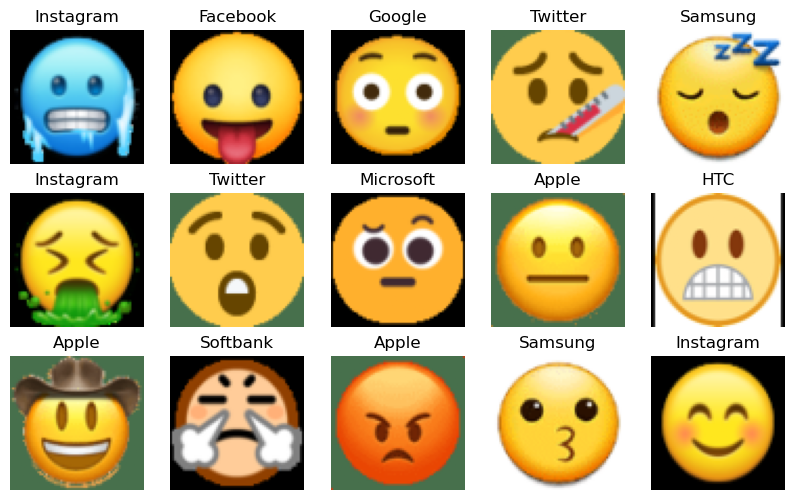

In [43]:
import random
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
    for ax in _ax:
        ix = random.randint(0, len(train)-1)
        img, lab = train[ix]
        ax.imshow(img.reshape(3,64,64).permute(1,2,0)*0.5+0.5)
        ax.set_title(classes[lab])
        ax.axis('off')
plt.show()

### Clase Generator

Esta clase es la encargada de generar datos nuevos a partir de un conjunto de datos de entrenamiento. El generador se compone de varias capas convolucionales y de capas de normalización. La salida del generador es una imagen de 64x64 píxeles. La entrada del generador es un vector de 100 elementos (en este caso ruido aleatorio).

In [44]:
import torch.nn as nn
import timm

class Generator(nn.Module):
    def __init__(self, channel=3, z_dim=100):
        super(Generator, self).__init__()
        self.channel = channel
        self.z_dim = z_dim

        # Crea una nueva arquitectura basada en ResNeSt-101e
        self.resnest = timm.create_model('resnest101e', pretrained=True)
        
        # Remueve la última capa (clasificación) de ResNeSt
        self.resnest = nn.Sequential(*list(self.resnest.children())[:-2])
        
        # Añade una capa completamente conectada para convertir el ruido en características iniciales
        self.fc = nn.Linear(self.z_dim, 2048 * 4 * 4)  # Ajustado para imágenes de 4x4
        self.bn = nn.BatchNorm2d(2048)
        
        # Añade capas de convolución transpuesta para aumentar el tamaño de la imagen
        self.deconv1 = nn.ConvTranspose2d(2048, 1024, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.deconv2 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(512)
        self.deconv3 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.deconv4 = nn.ConvTranspose2d(256, self.channel, kernel_size=4, stride=2, padding=1)
        
        # Función de activación final
        self.tanh = nn.Tanh()

    def forward(self, z):
        # Transforma el ruido inicial
        out = self.fc(z)
        out = out.view(out.size(0), 2048, 4, 4)  # Ajustado para imágenes de 4x4
        out = self.bn(out)
        
        # Capas de convolución transpuesta para aumentar el tamaño de la imagen a 64x64
        out = self.deconv1(out)
        out = self.bn1(out)
        out = self.deconv2(out)
        out = self.bn2(out)
        out = self.deconv3(out)
        out = self.bn3(out)
        out = self.deconv4(out)
        
        # Aplicar la función de activación para asegurarse de que los valores estén en el rango [-1, 1]
        out = self.tanh(out)
        out = out.view(out.size(0), self.channel* 64* 64)
        return out


Hacemos la prueba de generar una imagen a partir de un vector de ruido aleatorio para ver si el generador funciona correctamente.

In [45]:
generator = Generator()
output = generator(torch.randn(32, 100))
output.shape

torch.Size([32, 12288])

Mostramos la imagen generada por el generador.

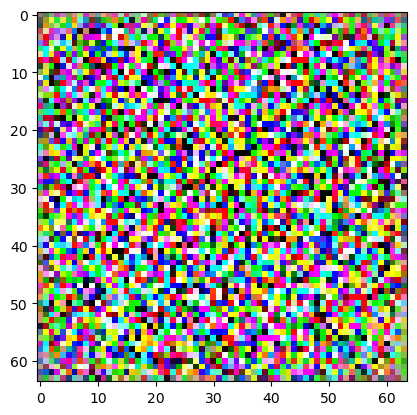

In [46]:
plt.imshow(output[0].view(3,64,64).permute(1,2,0).detach().numpy()*0.5+0.5)
plt.show()

### Clase Discriminator

Esta clase es la encargada de distinguir entre datos reales y datos generados por el generador. El discriminador se compone de varias capas convolucionales y de capas de normalización. La entrada del discriminador es una imagen de 64x64 píxeles. La salida del discriminador es un valor entre 0 y 1 que indica si la imagen es real o generada por el generador.

En este caso, haremos `Transfer Learning` del modelo preentrenado `resnet18` para que el discriminador sea más eficiente. El modelo resnet18 se ha entrenado con el dataset ImageNet, que contiene imágenes de objetos cotidianos. Y nosotros vamos a entrenar el discriminador con imágenes de caras de personas.

In [47]:
#import torchvision.models as models
import timm

class Discriminator(nn.Module):
  def __init__(self, channel):
    super().__init__()
    self.channel = channel
    # descargamos resnext
    resnest = timm.create_model('resnest101e', pretrained=True)
    # nos quedamos con todas las capas menos la última
    self.resnest = nn.Sequential(*list(resnest.children())[:-1])
    for param in self.resnest.parameters():
      param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = nn.Linear(2048, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = x.view(x.size(0), self.channel, 64, 64)
    x = self.resnest(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    y = self.sigmoid(x)
    return y

  def unfreeze(self):
    for param in self.resnest.parameters():
      param.requires_grad = True

Hacemos la prueba de pasar una imagen por el discriminador para ver si el discriminador funciona correctamente.

In [48]:
discriminator = Discriminator(channel=3)
output = discriminator(torch.randn(32, 3*64*64))
output.shape

torch.Size([32, 1])

In [49]:
# comprobar que los pesos del modelo resnext se hayan descargado correctamente
for name, param in discriminator.named_parameters():
    if param.requires_grad:
        print(f"Layer: {name}, Shape: {param.shape}, Mean Value: {param.mean().item()}, Std Dev: {param.std().item()}")

Layer: fc.weight, Shape: torch.Size([1, 2048]), Mean Value: 0.00027062627486884594, Std Dev: 0.01294421125203371
Layer: fc.bias, Shape: torch.Size([1]), Mean Value: -0.019167227670550346, Std Dev: nan


`isinstance` sirve para comprobar si un objeto es de una clase determinada. En este caso, usaremos esta herramienta para poder hacer el `unfreeze` de las capas del modelo resnet18 que aplicaremos en la funcion de entrenamiento `fit`.

In [50]:
isinstance(discriminator, Discriminator)

True

### Función de entrenamiento fit

Esta función es la encargada de entrenar al generador y al discriminador para que el generador genere datos que el discriminador no pueda distinguir de los datos reales.

En esta función de entrenamiento, el discriminador se entrena con imágenes reales y con imágenes generadas por el generador. El discriminador se entrena para que distinga entre imágenes reales y generadas por el generador. El generador se entrena para que genere imágenes que el discriminador no pueda distinguir de las imágenes reales. El objetivo es que el generador genere imágenes que el discriminador clasifique como reales.

El generador y el discriminador se entrenan por separado, primero se entrena el discriminador y luego se entrena el generador. Primero el discriminador se entre solo la ultima capa durante 5 `epochs`. Luego se entrena el discriminador con todas las capas durante las `epochs` que falten.

In [51]:
import numpy as np
from fastprogress.fastprogress import master_bar, progress_bar

def fit(g, d, dataloader, epochs=5, lr=3e-4, unfreeze=False):
    g.to(device)
    d.to(device)
    g_optimizer = torch.optim.Adam(g.parameters(), lr=lr)
    d_optimizer = torch.optim.Adam(d.parameters(), lr=lr)
    crit = nn.BCELoss()
    g_loss, d_loss = [], []
    mb = master_bar(range(1, epochs+1))
    hist = {'g_loss': [], 'd_loss': []}
    for epoch in mb:
        if (isinstance(d, Discriminator) and epoch == 5 and unfreeze == True):
            d.unfreeze()
        for X, y in progress_bar(dataloader, parent=mb):
            X, y = X.to(device), y.to(device)
            # entrenamos el discriminador
            g.eval()
            d.train()
            # generamos un batch de imágenes falsas
            noise = torch.randn((X.size(0), g.z_dim)).to(device)
            genenerated_images = g(noise)
            # input del discrminator
            d_input = torch.cat([genenerated_images, X.view(X.size(0), -1)])
            # gorund truth para el discriminator
            d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1,1).to(device)
            # optimización
            d_optimizer.zero_grad()
            d_output = d(d_input)
            d_l = crit(d_output, d_gt)
            d_l.backward()
            d_optimizer.step()
            d_loss.append(d_l.item())
            # entrenamos el generador
            g.train()
            d.eval()
            # generamos un batch de imágenes falsas
            noise = torch.randn((X.size(0), g.z_dim)).to(device)
            genenerated_images = g(noise)
            # salidas del discriminador
            d_output = d(genenerated_images)
            # gorund truth para el generator
            g_gt = torch.ones(X.size(0)).view(-1,1).to(device)
            # optimización
            g_optimizer.zero_grad()
            g_l = crit(d_output, g_gt)
            g_l.backward()
            g_optimizer.step()
            g_loss.append(g_l.item())
            # logs
            mb.child.comment = f'g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}'
        mb.write(f'Epoch {epoch}/{epochs} g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}')
        hist['g_loss'].append(np.mean(g_loss))
        hist['d_loss'].append(np.mean(d_loss))
        
        torch.save(g.state_dict(), 'models/generator_v1_' + str(epoch) + '.pth')
        torch.save(d.state_dict(), 'models/discriminator_v1_' + str(epoch) + '.pth')
    return hist

Entrenamos el generador y el discriminador:

- Primero entrenamos ambos modelos con 30 epochs con un learning rate de 0.0003 y un batch size de 64. Y guardamos los modelos entrenados para luego poder cargarlos y no tener que volver a entrenarlos.

- Luego entrenamos ambos modelos durante 20 epochs con un learning rate de 0.0002 pero con el modelo preentrenado que hemos guardado en el paso anterior. Y guardamos los modelos entrenados para luego poder cargarlos y no tener que volver a entrenarlos.

- Finalmente entrenamos ambos modelos durante 20 epochs con un learning rate de 0.0001 pero con el modelo preentrenado que hemos guardado en el paso anterior. Y guardamos los modelos entrenados para luego poder cargarlos y no tener que volver a entrenarlos.

Haciendo pruebas, he visto que entrenando el discriminador con todas las capas desde el principio, el discriminador no es capaz de distinguir entre imágenes reales y generadas por el generador. Por eso, he decidido entrenar primero el discriminador con solo la ultima capa y luego con todas las capas.

In [73]:
hist = fit(generator, discriminator, dataloader, epochs=20, lr=3e-4, unfreeze=False)

c:\Users\israe\anaconda3\envs\cuda_user\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


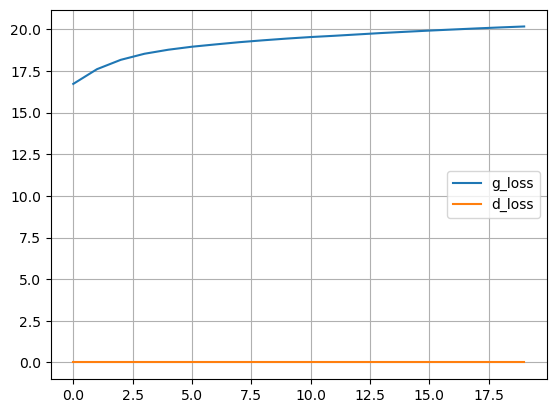

In [74]:
import pandas as pd

df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

### Pruebas del modelo

Hacemos pruebas del modelo para ver si el generador genera imágenes de rostros de personas.

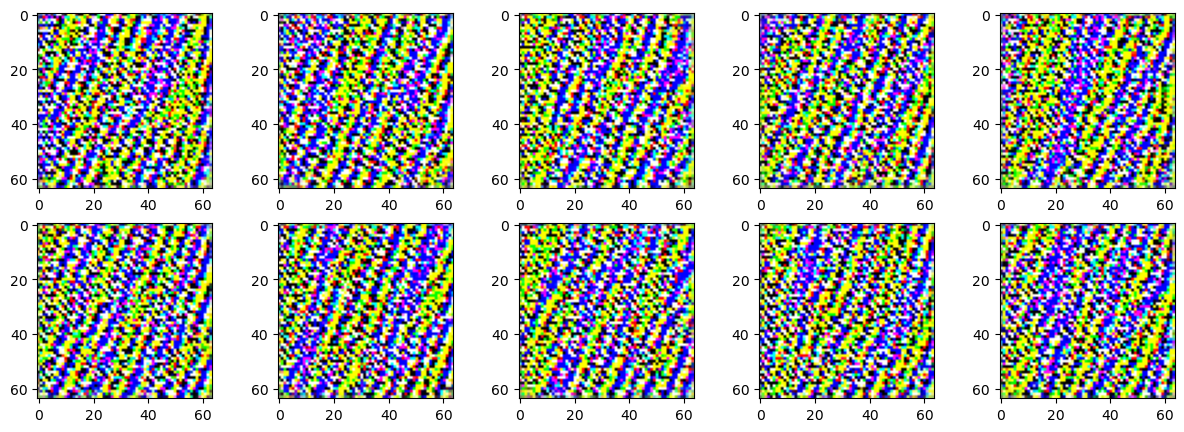

In [75]:
generator.eval().to(device)
with torch.no_grad():
  noise = torch.randn((10, generator.z_dim)).to(device)
  generated_images = generator(noise)
  fig, axs = plt.subplots(2,5,figsize=(15,5))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = (generated_images[i].view(3,64,64).permute(1,2,0).cpu())*0.5+0.5
      _ax.imshow(img)
      i+=1
  plt.show()

Como podemos ver aqui cargamos el modelo entrenado v6.20 esto quiere decir que entramos 6 veces el modelo guardando el modelo y volviendo a cargarlo y partir de ahi entrenar, hicimos esto durante 6 veces para que el modelo fuera mejorando y no se quedara estancado en un punto, cambiando algunos parametros como el learning rate y el batch size.

In [78]:
# cargar modelo entrenado
generator = Generator(channel=3)
generator.load_state_dict(torch.load('models/generator_v1_9.pth'))
discriminator = Discriminator(channel=3)
discriminator.load_state_dict(torch.load('models/discriminator_v1_19.pth'))

<All keys matched successfully>

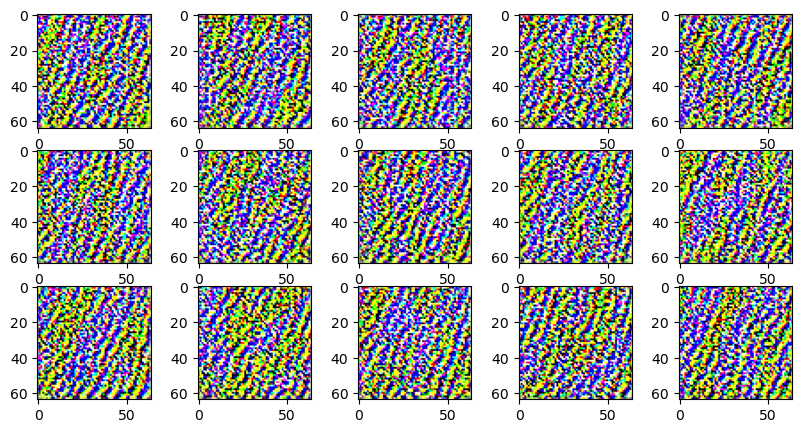

In [79]:
generator.eval().to(device)
with torch.no_grad():
  noise = torch.randn((15, generator.z_dim)).to(device)
  generated_images = generator(noise)
  fig, axs = plt.subplots(3,5,figsize=(10,5))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = (generated_images[i].view(3,64,64).permute(1,2,0).cpu())*0.5+0.5
      _ax.imshow(img)
      i+=1
  plt.show()

In [ ]:
generator

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=32768, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)